# K-Means & Genetic Algorithm for Vehicle Routing Problem (VRP)

In [1]:
''' Import Module '''
import random as rd
import numpy as np
import pandas as pd
import time
import copy

''' Set Parameters '''
NUM_NODES = 50
MAX_X = 100
MAX_Y = 100
NUM_VEHICLES = 5
NUM_DEPOT = 0

# 在 K-Means & GA 的 VRP 中，每個迭代的 Chromosome 數量要根據分群後的數量決定，故不給定母體大小參數
# POPULATION_SIZE = 4

CROSSOVER_RATE = 0.5
MUTATION_RATE = 0.5
NUM_ITERATIONS = 100

''' Set Data Model '''
def create_data_model():
    data = {}
    data["num_locations"] = [(rd.randint(1, MAX_X), rd.randint(1, MAX_Y)) for i in range(NUM_NODES)]
    data["distance_matrix"] = compute_manhattan_distance_matrix(data['num_locations'])
    data["num_vehicles"] = NUM_VEHICLES
    data["depot"] = NUM_DEPOT
    data["clusters"] = []
    data["i_clusters"] = [[] for i in range(NUM_VEHICLES)]
    return data

def compute_manhattan_distance_matrix(nodes):
    distance_matrix = []
    for node_i in nodes:
        distances = []
        for node_j in nodes:
            if node_i == node_j:
                distances.append(0)
            else:
                manhattan_distance = np.sum(np.abs(np.array(node_i) - np.array(node_j)))
                distances.append(manhattan_distance)
        distance_matrix.append(distances)
    return distance_matrix

def create_result_model():
    result = {}
    result['vehicle'] = []
    result['iteration'] = []
    result['num_crossover'] = []
    result['num_mutation'] = []
    result['duration'] = []
    result['routes'] = []
    result['shortest_route'] = []
    result['shortest_distance'] = []   
    return result

data = create_data_model()
result = create_result_model()

print("data['num_locations']:", data['num_locations'])
print("data['distance_matrix']:", data['distance_matrix'])

data['num_locations']: [(21, 94), (99, 51), (52, 93), (100, 20), (19, 77), (91, 21), (32, 41), (80, 41), (54, 83), (89, 69), (82, 18), (95, 100), (1, 86), (97, 97), (93, 76), (98, 98), (98, 46), (69, 40), (71, 65), (31, 38), (83, 17), (34, 55), (17, 23), (51, 11), (84, 52), (71, 60), (56, 6), (86, 7), (89, 27), (22, 6), (88, 92), (85, 86), (32, 45), (92, 36), (94, 17), (49, 80), (23, 92), (12, 77), (84, 28), (49, 7), (92, 8), (60, 1), (5, 32), (92, 11), (83, 55), (73, 74), (8, 77), (41, 80), (24, 48), (20, 27)]
data['distance_matrix']: [[0, 121, 32, 153, 19, 143, 64, 112, 44, 93, 137, 80, 28, 79, 90, 81, 125, 102, 79, 66, 139, 52, 75, 113, 105, 84, 123, 152, 135, 89, 69, 72, 60, 129, 150, 42, 4, 26, 129, 115, 157, 132, 78, 154, 101, 72, 30, 34, 49, 68], [121, 0, 89, 32, 106, 38, 77, 29, 77, 28, 50, 53, 133, 48, 31, 48, 6, 41, 42, 81, 50, 69, 110, 88, 16, 37, 88, 57, 34, 122, 52, 49, 73, 22, 39, 79, 117, 113, 38, 94, 50, 89, 113, 47, 20, 49, 117, 87, 78, 103], [32, 89, 0, 121, 49, 111, 

In [2]:
''' Plot the nodes and routes '''
import matplotlib.pyplot as plt
import seaborn as sns

def plot_map():
    sns.set()
    plt.figure(figsize=(7, 7))
    plt.title('Vehicle Route Problem (VRP) solved by GA')
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
    plt.xlim(0, MAX_X)
    plt.ylim(0, MAX_Y)
    try:
        plotted_routes = copy.deepcopy(routes)
        for index, route in enumerate(plotted_routes):
            plotted_routes[index][0:0] = [0]

        for route in plotted_routes:
            # Draw lines
            RGB_colors = tuple(round(rd.uniform(0,1), 1) for i in range(3))
            arrow_kwargs = dict(length_includes_head=True, head_width=2.5, head_length=5, color=RGB_colors, alpha=0.8)

            for index, node in enumerate(route):
                start_loc = data['num_locations'][route[index]]
                end_loc = data['num_locations'][route[index + 1]] if index < (len(route) - 1) else data['num_locations'][0]

                plt.arrow(x=start_loc[0], y=start_loc[1], dx=(end_loc[0] - start_loc[0]), dy=(end_loc[1] - start_loc[1]), **arrow_kwargs)

            # Draw nodes
            for i in route:
                text_kwargs = dict(s=str(i), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                node_kwargs = dict(s=500, color='black', alpha=0.8, edgecolors='black')

                if i == 0: 
                    continue
                node_kwargs['color'] = RGB_colors
                node = data['num_locations'][i]
                plt.scatter(x=node[0], y=node[1], **node_kwargs)
                plt.text(x=node[0], y=node[1], **text_kwargs)
            
            # Draw start node
            start_node = data['num_locations'][0]
            plt.scatter(x=start_node[0], y=start_node[1], s=500, color='black', alpha=0.8, edgecolors='black') 
            plt.text(x=start_node[0], y=start_node[1], s='0', fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
    except:
        if len(data['num_locations']) > 0:
            # 有經過分群, 畫出每個點 & 區分不同顏色
            if len(data["clusters"]) > 0:
                for i_cluster in data["clusters"]:
                    node_kwargs = dict(s=500, color='black', alpha=0.8, edgecolors='black')
                    RGB_colors = tuple(round(rd.uniform(0,1), 1) for i in range(3))
                    node_kwargs['color'] = RGB_colors
                    for index, node in enumerate(i_cluster):
                        if index == 0:
                            plt.scatter(x=node[0], y=node[1], s=500, color='black', alpha=0.8, edgecolors='black') 
                            plt.text(x=node[0], y=node[1], s='0', fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                            continue
                        text_kwargs = dict(s=str(data['num_locations'].index(node)), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                        plt.scatter(x=node[0], y=node[1], **node_kwargs)
                        plt.text(x=node[0], y=node[1], **text_kwargs)
            # 尚未分群, 僅畫出每個點
            else:
                for index, node in enumerate(data['num_locations']):
                    text_kwargs = dict(s=str(index), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                    node_kwargs = dict(s=500, color='gray', alpha=0.8, edgecolors='black')
                    if index == 0: 
                        plt.scatter(x=node[0], y=node[1], s=500, color='black', alpha=0.8, edgecolors='black') 
                        plt.text(x=node[0], y=node[1], s='0', fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                        continue
                    plt.scatter(x=node[0], y=node[1], **node_kwargs)
                    plt.text(x=node[0], y=node[1], **text_kwargs)
        else:
            print("No data to plot.")

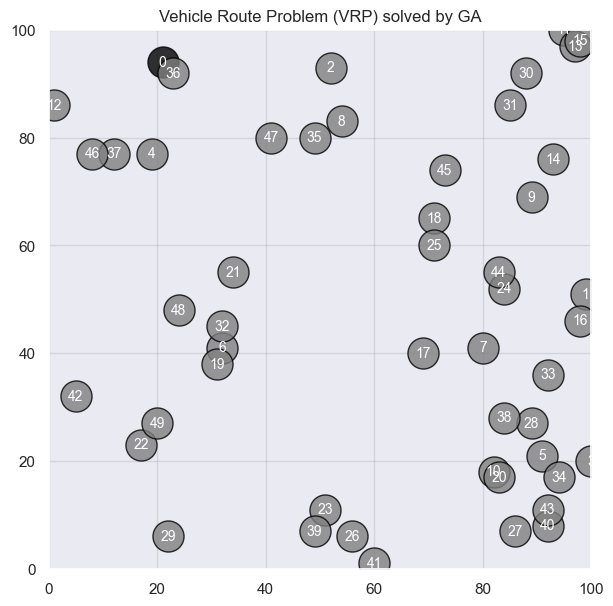

In [3]:
plot_map()

In [4]:
''' K-Means Clustering '''
def k_means_clustering():
    x, y = [i[0] for i in data['num_locations']], [i[1] for i in data['num_locations']]
    kx, ky = [x[i] for i in range(NUM_VEHICLES)], [y[i] for i in range(NUM_VEHICLES)]
    num_iteration = 0
    max_iteration = 100

    def mht_dist(x1,y1,x2,y2):
        return round(abs(x1-x2) + abs(y1-y2), 2)
    
    def get_centroid(x_cluster, y_cluster):
        next_kx, next_ky = [], []
        for i in range(len(x_cluster)):
            next_kx.append(round(sum(x_cluster[i]) / len(x_cluster[i]),2))
            next_ky.append(round(sum(y_cluster[i]) / len(y_cluster[i]),2))
        return next_kx, next_ky

    start = True
    while start:
        if num_iteration == max_iteration:
            print('Iteration max reached!')
            break
        ''' Iteration of K-Means '''
        iter_dist = []
        for i in range(len(x)):
            dist = []
            for k in range(len(kx)):
                dist.append(mht_dist(x[i],y[i],kx[k],ky[k]))
            iter_dist.append(dist)

        x_cluster = [[] for i in range(1, len(kx) + 1)]
        y_cluster = [[] for i in range(1, len(kx) + 1)]
        
        for i, list in enumerate(iter_dist):
            x_cluster[list.index(min(list))].append(x[i])
            y_cluster[list.index(min(list))].append(y[i])
        # print(f'x_cluster = {x_cluster}, y_cluster = {y_cluster}')
        next_kx, next_ky = get_centroid(x_cluster, y_cluster)
        # print(f'next_kx = {next_kx}, next_ky = {next_ky}')

        if next_kx == kx and next_ky == ky:
            print('Converged!', '\n')
            start = False
            clusters = [[] for i in range(len(x_cluster))]
            for i, cluster in enumerate(x_cluster):
                for j, value in enumerate(cluster):
                    clusters[i].append((x_cluster[i][j], y_cluster[i][j]))
            return clusters
        else:
            kx, ky = next_kx, next_ky

        num_iteration += 1
        print(f'Iteration {num_iteration} completed!')

clusters = k_means_clustering()

for i_cluster, cluster in enumerate(clusters):
    if cluster[0] != data['num_locations'][0]:
        clusters[i_cluster].insert(0, data['num_locations'][0])
    for value in cluster:
        data['i_clusters'][i_cluster].append(data['num_locations'].index(value))

data['clusters'] = clusters

print('Clusters:', data['clusters'])
print('Index of Clusters', data['i_clusters'])

Iteration 1 completed!
Iteration 2 completed!
Iteration 3 completed!
Iteration 4 completed!
Converged! 

Clusters: [[(21, 94), (19, 77), (54, 83), (1, 86), (49, 80), (23, 92), (12, 77), (8, 77), (41, 80)], [(21, 94), (99, 51), (80, 41), (89, 69), (98, 46), (69, 40), (71, 65), (84, 52), (71, 60), (92, 36), (83, 55)], [(21, 94), (52, 93), (95, 100), (97, 97), (93, 76), (98, 98), (88, 92), (85, 86), (73, 74)], [(21, 94), (100, 20), (91, 21), (82, 18), (83, 17), (51, 11), (56, 6), (86, 7), (89, 27), (94, 17), (84, 28), (49, 7), (92, 8), (60, 1), (92, 11)], [(21, 94), (32, 41), (31, 38), (34, 55), (17, 23), (22, 6), (32, 45), (5, 32), (24, 48), (20, 27)]]
Index of Clusters [[0, 4, 8, 12, 35, 36, 37, 46, 47], [0, 1, 7, 9, 16, 17, 18, 24, 25, 33, 44], [0, 2, 11, 13, 14, 15, 30, 31, 45], [0, 3, 5, 10, 20, 23, 26, 27, 28, 34, 38, 39, 40, 41, 43], [0, 6, 19, 21, 22, 29, 32, 42, 48, 49]]


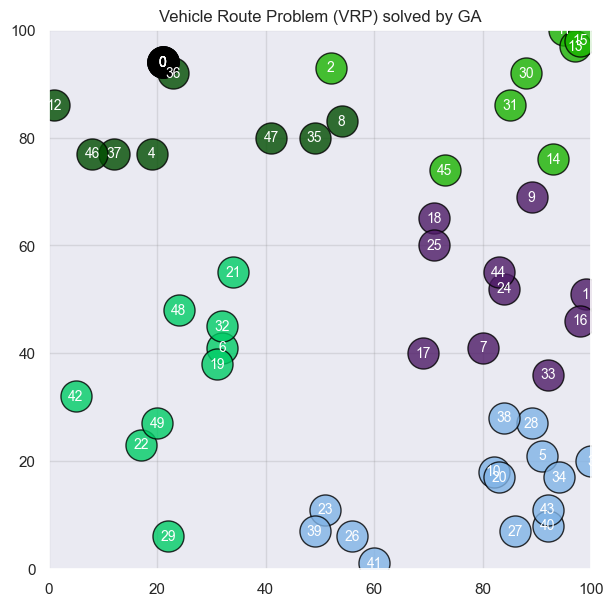

In [5]:
plot_map()

In [39]:
def solve_TSP_by_GA(i_cluster, cluster):

    def create_initial_solution(i_cluster, cluster):
        initial_routes = []

        if len(cluster) < population_size:
            print(f"Error: len(cluster):{len(cluster)} must be greater than population_size {population_size}. Please increase nodes or decrease population szie!")
            return
        
        def do_greedy_algorithm_for_VRP(start_index, i_locations, locations):
            order = [start_index]
            distance_matrix = compute_manhattan_distance_matrix(locations)

            def do_iteration(node_index):
                if len(order) == (len(locations) - 1):
                    order.append(0)
                    return
                else:
                    distance_matrix[node_index][0] = 999999
                    distance_matrix[node_index][node_index] = 999999
                    next_index = distance_matrix[node_index].index(min(distance_matrix[node_index]))
                    order.append(next_index)
                    for i in range(len(distance_matrix)):
                        distance_matrix[i][node_index] = 999999

                    return do_iteration(next_index)

            do_iteration(start_index)
            optimal_route = []
            for i in order:
                optimal_route.append(i_locations[i])
            
            return optimal_route

        indexes = rd.sample([i for i in range(1, len(cluster))], population_size - 1)
        for index in indexes:
            initial_routes.append(do_greedy_algorithm_for_VRP(index, data['i_clusters'][i_cluster], cluster))
        
        return initial_routes
    
    def do_crossover(routes):
        num_crossover = 0
        for i in range(0, len(routes), 2):
        
            if i + 1 < len(routes):
                route1 = routes[i]
                route2 = routes[i + 1]
                if len(route1) == len(route2):
                    prob = rd.random()
                    if CROSSOVER_RATE > prob:
                        parent1, parent2 = route1.copy(), route2.copy()            
                        interval = rd.sample([i for i in range(0, len(parent1) - 2)], 2) # 隨機決定交配的基因片段起始位置
                        start, end = min(interval), max(interval)

                        genes1 = parent1[start:end] # 取得要進行交配的基因片段
                        offspring1 = [i for i in parent2 if i not in genes1] # 將 parent2 中重複的基因片段移除, 其餘遺傳給子代 offspring1
                        index = rd.randint(0, len(offspring1) - 1) # 隨機決定插入基因片段的位置索引值, 
                        offspring1[index:index] = genes1 # 將基因片段插入子代中

                        genes2 = parent2[start:end]
                        offspring2 = [i for i in parent1 if i not in genes2]
                        offspring2[index:index] = genes2

                        routes += [offspring1, offspring2]
                        num_crossover += 1
                else:
                    print("Error: The length of two chromosome are not equal.")
        return routes, num_crossover

    def do_mutation(routes):
        num_mutation = 0
        for i in range(len(routes)):
            route = routes[i] 
            chromosome = route.copy()
            prob = rd.random()
            if MUTATION_RATE > prob:
                num_mutation = rd.randint(1, len(chromosome)-1) # 隨機決定突變的基因數量
                mutation_indexes = rd.sample([i for i in range(0, len(chromosome)-1)], num_mutation) # 隨機決定突變的基因位置
                mutation_genes = [chromosome[i] for i in mutation_indexes] # 取得突變的基因
                rd.shuffle(mutation_genes) # 突變開始, 隨機排序基因
                for index, i in enumerate(mutation_indexes): # 依序將突變後的基因放回染色體
                    chromosome[i] = mutation_genes[index]
                    routes += [chromosome]
                    num_mutation += 1
        return routes, num_mutation

    def do_selection(chromosomes):
        chromosomes = list(set([tuple(chromosome) for chromosome in chromosomes])) # remove duplicated chromosomes (list -> set -> list)
        chromosomes = [list(chromosome) for chromosome in chromosomes]

        if len(chromosomes) < population_size:
            # print(f'Chromosomes is less than {population_size}. Regenerate chromosomes...')
            chromosomes += create_initial_solution(i_cluster, cluster)
        chromosomes.sort(key=lambda x: get_objective_value(x))
        return chromosomes[:population_size]

    ''' TSP 主程式 '''
    population_size = rd.randint(2, len(cluster)) # 根據每個群集大小決定每次迭代的母體數量, 群集最小數量為 2
    initial_routes = create_initial_solution(i_cluster, cluster)
    # print(f"Initial Route of Cluster {i_cluster + 1}: {initial_routes}") 
    
    # 某些集群的數量只有 2, 已為唯一解可直接回傳路徑
    if len(cluster) == 2:
        # print(f"Initial Solution of Cluster {i_cluster + 1}: {initial_routes[0]}")
        return initial_routes[0]

    routes = do_selection(initial_routes)
    # print(f"Initial Solution of Cluster {i_cluster + 1}: {routes}")

    iteration = 0

    while NUM_ITERATIONS > iteration:
        start_time = time.time()
        routes, num_crossover = do_crossover(routes)
        routes, num_mutation = do_mutation(routes)
        routes = do_selection(routes)
        end_time = time.time()
        iteration += 1
        # print("Iteration:", iteration, "Solution:", routes, "\n")

        output = {
            'vehicle': i_cluster + 1,
            'iteration': iteration, 
            'num_crossover': num_crossover, 
            'num_mutation': num_mutation, 
            'duration': round(end_time - start_time, 5), 
            'routes': routes, 
            'shortest_route': routes[0], 
            'shortest_distance': get_objective_value(routes[0])
        }

        global result    
        for key in result:
            result[key].append(output[key])

    fitness_values = [get_objective_value(route) for index, route in enumerate(routes)]
    # print("Final Solution:", routes, "\n")
    return routes[fitness_values.index(min(fitness_values))]

def get_objective_value(route):
    objective_value = 0
    for i in range(len(route) - 1):
        objective_value += data['distance_matrix'][route[i]][route[i+1]]
    return objective_value

def print_solution(routes):
    total_distance = 0
    for vehicle_id in range(0,len(routes)):
        index = 0
        plan_output = f"Route for vehicle {vehicle_id + 1}:\n0 -> "
        route_distance = get_objective_value(routes[vehicle_id])
        total_distance += route_distance
        while index < len(routes[vehicle_id]) - 1:
            plan_output += f" {routes[vehicle_id][index]} -> "
            index += 1
        plan_output += f"0\nDistance of the route: {route_distance} m\n"
        print(plan_output)
    print(f"Total distance: {total_distance} m")

In [41]:
def main():

    routes = []
    # 針對每個群集使用 GA 解 TSP
    for i_cluster, cluster in enumerate(data['clusters']):
        sub_routes = solve_TSP_by_GA(i_cluster, cluster)        
        routes.append(sub_routes) 

    return routes

routes = main()
print_solution(routes)

Route for vehicle 1:
0 ->  8 ->  35 ->  47 ->  4 ->  37 ->  46 ->  12 ->  36 -> 0
Distance of the route: 100 m

Route for vehicle 2:
0 ->  9 ->  44 ->  24 ->  1 ->  16 ->  33 ->  7 ->  17 ->  25 ->  18 -> 0
Distance of the route: 197 m

Route for vehicle 3:
0 ->  13 ->  15 ->  11 ->  30 ->  31 ->  14 ->  45 ->  2 -> 0
Distance of the route: 143 m

Route for vehicle 4:
0 ->  3 ->  34 ->  5 ->  28 ->  38 ->  10 ->  20 ->  43 ->  40 ->  27 ->  26 ->  41 ->  23 ->  39 -> 0
Distance of the route: 249 m

Route for vehicle 5:
0 ->  29 ->  22 ->  49 ->  42 ->  19 ->  6 ->  32 ->  48 ->  21 -> 0
Distance of the route: 169 m

Total distance: 858 m


In [42]:
pd.DataFrame(result).head(5)

,vehicle,iteration,num_crossover,num_mutation,duration,routes,shortest_route,shortest_distance
0,1,1,2,10,0.00016,"[[8, 35, 47, 4, 37, 46, 12, 36, 0], [35, 8, 47...","[8, 35, 47, 4, 37, 46, 12, 36, 0]",100
1,1,2,3,6,0.00010,"[[8, 35, 47, 4, 37, 46, 12, 36, 0], [35, 8, 47...","[8, 35, 47, 4, 37, 46, 12, 36, 0]",100
2,1,3,0,10,0.00005,"[[8, 35, 47, 4, 37, 46, 12, 36, 0], [35, 8, 47...","[8, 35, 47, 4, 37, 46, 12, 36, 0]",100
3,1,4,1,2,0.00006,"[[8, 35, 47, 4, 37, 46, 12, 36, 0], [35, 8, 47...","[8, 35, 47, 4, 37, 46, 12, 36, 0]",100
4,1,5,1,4,0.00005,"[[8, 35, 47, 4, 37, 46, 12, 36, 0], [35, 8, 47...","[8, 35, 47, 4, 37, 46, 12, 36, 0]",100


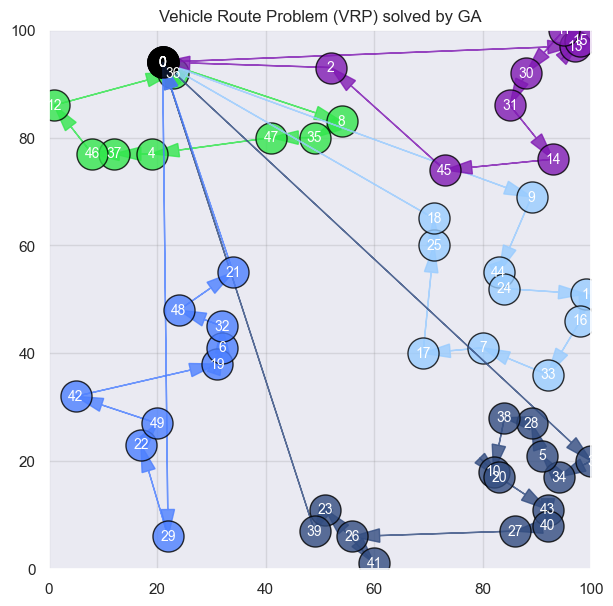

In [43]:
plot_map()